In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import normalize
import re
import seaborn as sns
from scipy import stats
import xgboost as xgb
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [20]:
orig_data = pd.read_excel("OppScrData.xlsx")
#print(orig_data)
for col in orig_data.columns:
    if 'Unnamed' in col:
        orig_data.drop(columns=col, inplace=True)
    else:
        new_col = '_'.join(col.split())
        orig_data.rename(columns={col:new_col}, inplace=True)
#for col in orig_data.columns:
#    print(col)
#print(orig_data.columns)
#print(orig_data)

In [21]:
data = orig_data.copy()

##Can use clinal_fu_Interval to get weights of clinical features

ct_feats = ['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)', 
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
clinal_feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)', 'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx']

all_feats = ct_feats + clinal_feats
other_feats = ['Record_ID', 'Visit_ID', 'PT_ID']
outcome = ['DEATH_[d_from_CT]']

myfilter = []
myfilter.extend(ct_feats)
myfilter.extend(outcome)

data_ct = data.loc[:, myfilter]

myfilter.extend(clinal_feats)

data_clincal = data.loc[:, myfilter]

data = data_ct
#data = data_clincal

#print(data.shape)

col = 'Liver_HU_(Median)'
data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
data.loc[:, col] = data[col].astype(float)
#print(data)

col = 'DEATH_[d_from_CT]'
#print(data.head(10))
#print(orig_data)
#data.loc[~data[col].isna(), col] = 1
#data.loc[data[col].isna(), col] = 0
#print(data.shape)
#print(data[col])
#print(data.head(10))
#print(data.loc[data[col] == 0, :].shape)
data.rename(columns={col:'death'}, inplace=True)
col = 'death'
#print(data.head(10))
#print(data.loc[data[col] == 0, :].shape)
#print(train.shape)
#print(test)
label = col

#print(data.loc[18, label])

5070.0


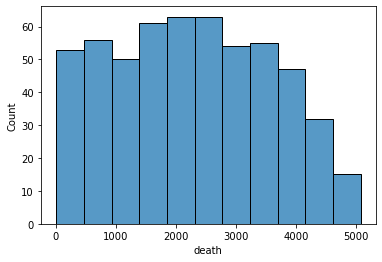

0.0
0.1111111111111111
0.0
563.3333333333333
11.275661349376177
0.26743979351863867


<AxesSubplot:xlabel='death_recency', ylabel='Count'>

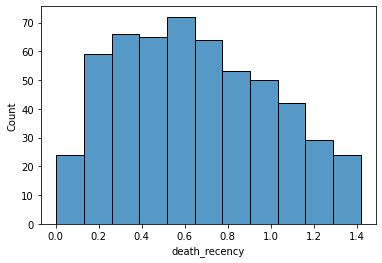

In [22]:
#print(all_feats)
data[label] = data[label].fillna(0)
#print(data[label])
sns.histplot(data.loc[data[label] > 0, label])
val_range = max(data[label]) - min(data[label])
print(val_range)
plt.show()
#for i in range(len(data[label])):
#    if data[i, label] > 0:
#        data[i]['death_recency'] = val_range/data[i][label]
data.loc[data[label] == 0 ,'death_recency'] = 0
data.loc[data[label] > 0 ,'death_recency'] = 1/data[label]

print(min(data['death_recency']))
print(max(data['death_recency']))
data['death_recency'] = data['death_recency'] * val_range
#data['death_recency'] = data['death_recency'].fillinf(0)
print(min(data['death_recency']))
print(max(data['death_recency']))

data_nz = data.loc[data['death_recency'] > 0, :].copy()
#X = data_nz['death_recency'].copy()
print(pd.Series(data_nz['death_recency']).skew())
data_nz['death_recency'] = stats.boxcox(data_nz['death_recency'])[0]
print(pd.Series(data_nz['death_recency']).skew())

data.loc[data['death_recency'] > 0, 'death_recency'] = data_nz['death_recency']

sns.histplot(data.loc[data['death_recency'] > 0, 'death_recency'])

In [31]:
data_2 = data.copy()

data_2 = data_2.drop(columns='death')
label = 'death_recency'

data_nz = data_2.loc[data_2[label] > 0].copy()


# for i in ['TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)', 'SAT_Area_(cm2)']:
#     if i in ct_feats:
#         ct_feats.remove(i)

msk = np.random.rand(data_nz.shape[0]) < 0.8
#print(msk)
train = data_nz[msk]
test = data_nz[~msk]

X_train = train[ct_feats]
#X_train = train[all_feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test[ct_feats]
# X_test = test[all_feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(443, 11)
(443,)
(105, 11)
(105,)


In [32]:
#print(X_train)
#print(y_train)
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=1, colsample_bytree=1)
model.fit(X_train, y_train)
#model = LinearRegression().fit(X_train, y_train)

#model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % np.mean(scores))

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
#print(Counter(Y_test))
preds = model.predict(X_test)
print("MSE=", math.sqrt(mean_squared_error(Y_test, preds)))
print("test_mean=", Y_test.mean())

MSE= 0.35448626099553954
test_mean= 0.6200736436516571


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

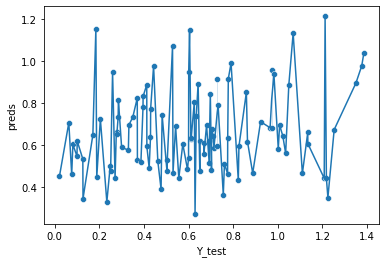

In [34]:
tmp = {'Y_test':Y_test,'preds':preds} 
# tmp_df = pd.DataFrame([Y_test, preds], columns=['Y_test','preds'])
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.lineplot(data=tmp_df, x='Y_test', y='preds')
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [35]:
##use this model to predict on rows of data that are zeros. expect average prediction to be higher.
#data_2 = data.copy()

# data_2 = data_2.drop(columns='death')
# label = 'death_recency'

#data_2 = data_2.drop(columns='death_recency')
#label = 'death'


#data_2 = data_2.loc[data_2[label] > 0]

msk = np.random.rand(data_2.shape[0]) < 0.8
#print(msk)
train = data_2[msk]
test = data_2[~msk]

X_train = train[ct_feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test[ct_feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(7333, 11)
(7333,)
(1890, 11)
(1890,)


In [36]:
#print(Counter(Y_test))
preds = model.predict(X_test)
print("MSE=", math.sqrt(mean_squared_error(Y_test, preds)))
print("test_mean=", Y_test.mean())

MSE= 0.6343093275999656
test_mean= 0.03927082139380123


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

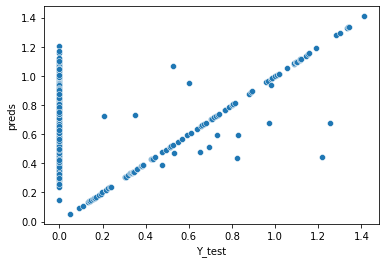

In [37]:
tmp = {'Y_test':Y_test,'preds':preds} 
# tmp_df = pd.DataFrame([Y_test, preds], columns=['Y_test','preds'])
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
#sns.lineplot(data=tmp_df, x='Y_test', y='preds')
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [44]:
tmp_nz_df = tmp_df[~(tmp_df['Y_test'] == 0)]
ytest_nz = tmp_nz_df['Y_test']
pred_nz = tmp_nz_df['preds']


print("MSE=", math.sqrt(mean_squared_error(ytest_nz, pred_nz)))
print("test_mean=", ytest_nz.mean())


MSE= 0.13736962160043525
test_mean= 0.651068881002494


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

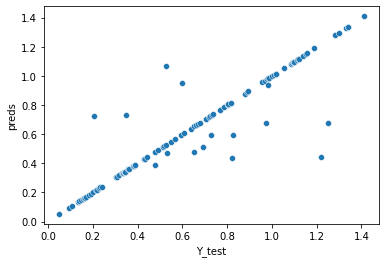

In [45]:
sns.scatterplot(data=tmp_nz_df, x='Y_test', y='preds')